<a href="https://colab.research.google.com/github/UjwalaRagaRoshini/DL-LAB/blob/main/Bi_temperd_logistic_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/surmenok/keras_lr_finder.git keras_lr_finder_repo
!mv keras_lr_finder_repo/keras_lr_finder keras_lr_finder
!git clone https://github.com/google/bi-tempered-loss.git
!mv bi-tempered-loss/tensorflow/loss.py loss.py
!rm -r keras_lr_finder_repo bi-tempered-loss

Cloning into 'keras_lr_finder_repo'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 68 (delta 1), reused 2 (delta 0), pack-reused 62
Receiving objects: 100% (68/68), 55.78 KiB | 6.20 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Cloning into 'bi-tempered-loss'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 152 (delta 15), reused 11 (delta 5), pack-reused 122
Receiving objects: 100% (152/152), 65.60 KiB | 10.93 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [2]:
!git clone https://github.com/DumalaAnveshini/bitempered.git
from bitempered.utils import generate_points, mix_cifar, mix_points, points_to_data, get_best_lr

Cloning into 'bitempered'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 740.39 KiB | 18.06 MiB/s, done.


In [3]:
from bitempered.plotting import plot_cifar, plot_points, plot_synthetic_results, plot_cifar_results, plot_lr_finding_results

In [4]:
from loss import _internal_bi_tempered_logistic_loss as bi_tempered_logistic_loss
from keras_lr_finder.lr_finder import LRFinder

In [5]:
import ssl

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, InputLayer, UpSampling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

In [6]:
class BiTemperedWrapper:

    def __init__(self, t1=1., t2=1.):
        self.t1 = t1
        self.t2 = t2
        self.cce = CategoricalCrossentropy(from_logits=True)

    def __call__(self, labels, activations):
        if self.t1 == 1. and self.t2 == 1.:
            return self.cce(labels, activations)
        return bi_tempered_logistic_loss(activations, labels, self.t1,  self.t2)

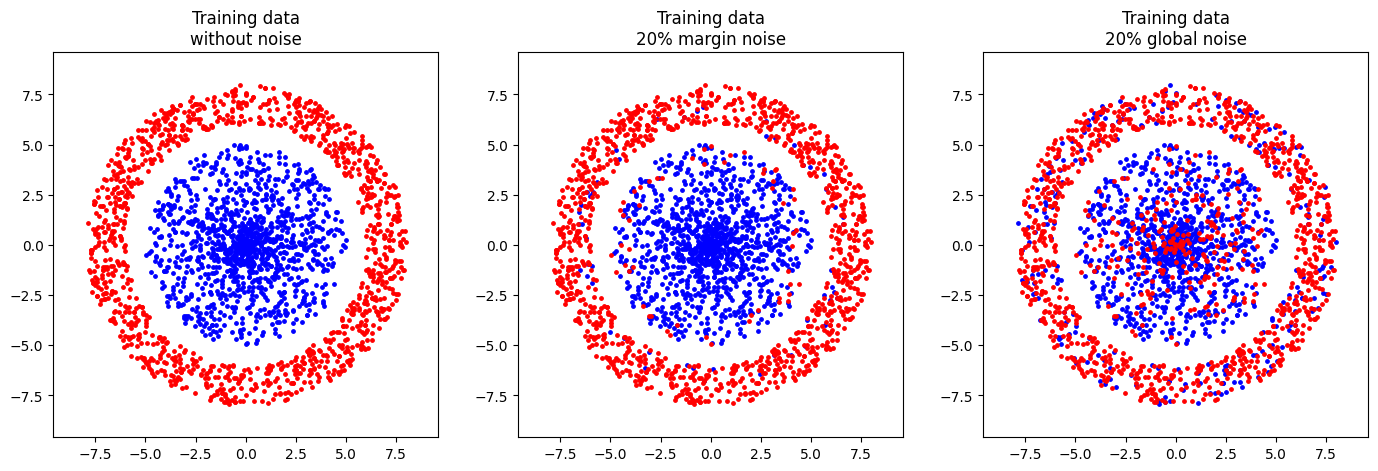

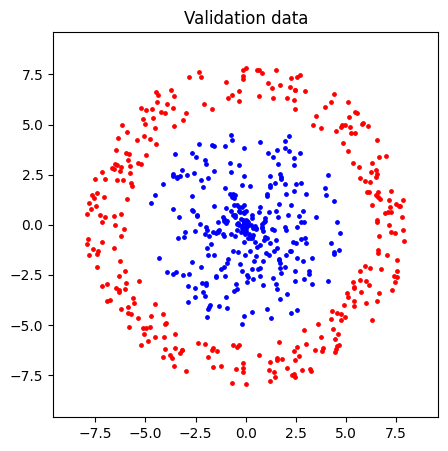

In [7]:
blue_train = generate_points(1200, 0, 5)
red_train = generate_points(1200, 6, 8)
blue_train_margin_noise, red_train_margin_noise = np.copy(blue_train), np.copy(red_train)
blue_train_global_noise, red_train_global_noise = np.copy(blue_train), np.copy(red_train)

mix_points(blue_train_margin_noise, red_train_margin_noise, 4, 7, 0.2)
mix_points(blue_train_global_noise, red_train_global_noise, 0, 8, 0.2)

plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.title("Training data\nwithout noise")
plot_points([blue_train, red_train], 8)

plt.subplot(1, 3, 2)
plt.title("Training data\n20% margin noise")
plot_points([blue_train_margin_noise, red_train_margin_noise], 8)

plt.subplot(1, 3, 3)
plt.title("Training data\n20% global noise")
plot_points([blue_train_global_noise, red_train_global_noise], 8)
plt.show()

plt.figure(figsize=(6, 5))
blue_valid = generate_points(300, 0, 5)
red_valid = generate_points(300, 6, 8)
plt.title("Validation data")
plot_points([blue_valid, red_valid], 8)
plt.show()

In [8]:
X_train, y_train = points_to_data(blue_train, red_train)
X_train_margin, y_train_margin = points_to_data(blue_train_margin_noise, red_train_margin_noise)
X_train_global, y_train_global = points_to_data(blue_train_global_noise, red_train_global_noise)

X_valid, y_valid = points_to_data(blue_valid, red_valid)

In [10]:
def synthetic_model():
    return Sequential([
        InputLayer(input_shape=X_train[0].shape),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(2)
    ])

In [11]:
datasets = {'noise free': (X_train, y_train),
            'margin': (X_train_margin, y_train_margin),
            'global': (X_train_global, y_train_global)}
temp_vals = [(1., 1.), (0.2, 4.0)]
results = {}
for dataset_name, (X_data, y_data) in datasets.items():
    results[dataset_name] = {}
    for temps in temp_vals:
        results[dataset_name][temps] = {}
        model = synthetic_model()
        model.compile(loss=BiTemperedWrapper(*temps), optimizer=Adam(), metrics=['accuracy'])
        history = model.fit(X_data, y_data, validation_data=(X_valid, y_valid), epochs=20)
        results[dataset_name][temps]['model'] = model
        results[dataset_name][temps]['history'] = history.history

Epoch 1/20
75/75 [==============================] - 2s 12ms/step - loss: 0.5629 - accuracy: 0.6292 - val_loss: 0.4908 - val_accuracy: 0.7417
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 0.4217 - accuracy: 0.8146 - val_loss: 0.3166 - val_accuracy: 0.8867
Epoch 3/20
75/75 [==============================] - 0s 5ms/step - loss: 0.2425 - accuracy: 0.9342 - val_loss: 0.1635 - val_accuracy: 0.9717
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.1340 - accuracy: 0.9792 - val_loss: 0.0947 - val_accuracy: 0.9950
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0806 - accuracy: 0.9954 - val_loss: 0.0580 - val_accuracy: 1.0000
Epoch 6/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.9983 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 0.9967
Epoch 8/20
75/75 [=

82/82 [==============================] - 0s 2ms/step


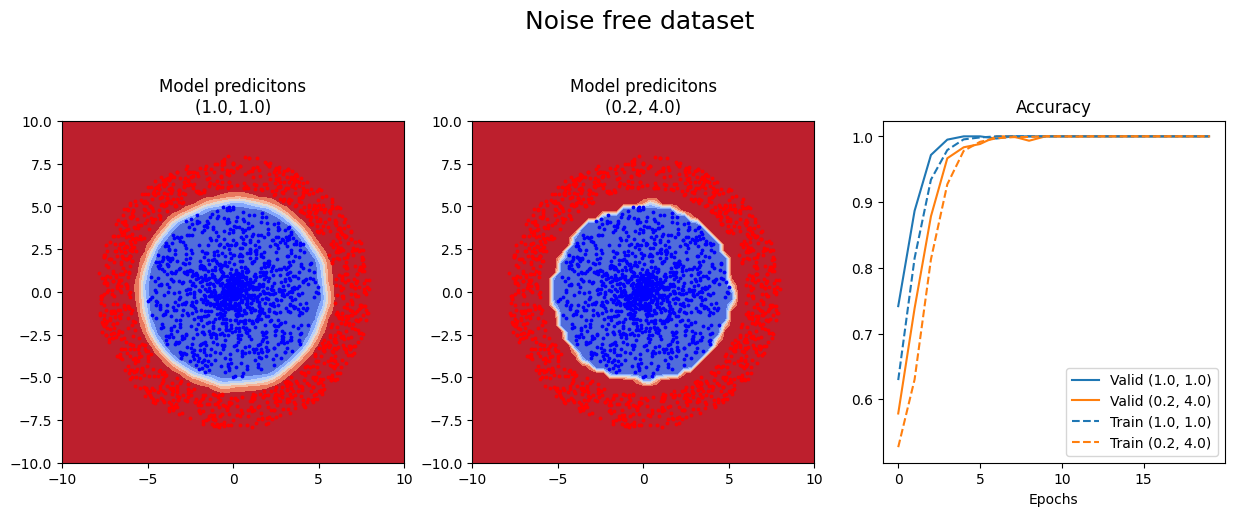

82/82 [==============================] - 0s 1ms/step


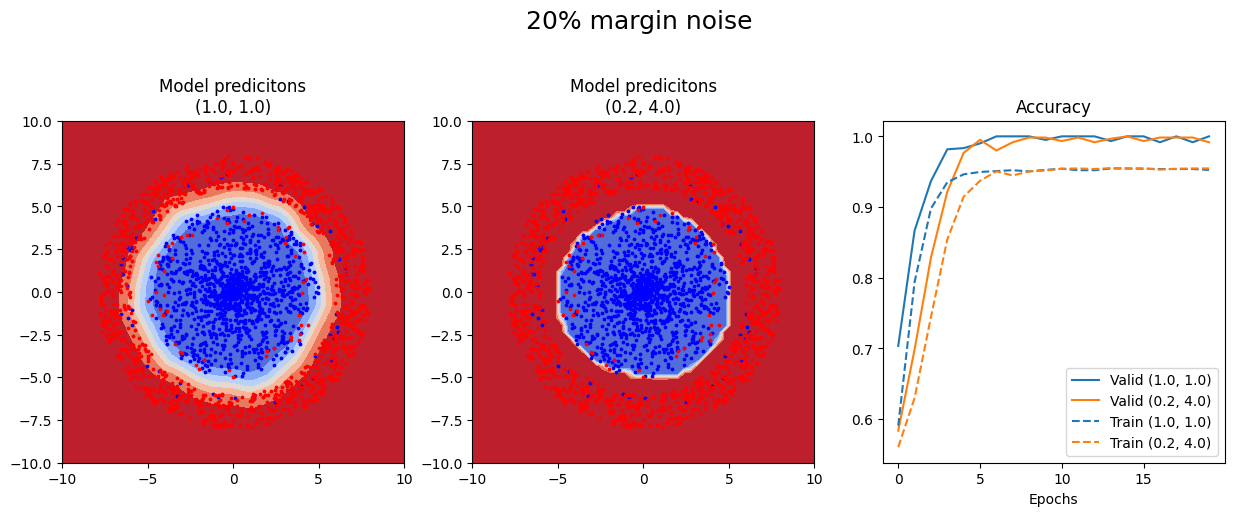

82/82 [==============================] - 0s 2ms/step


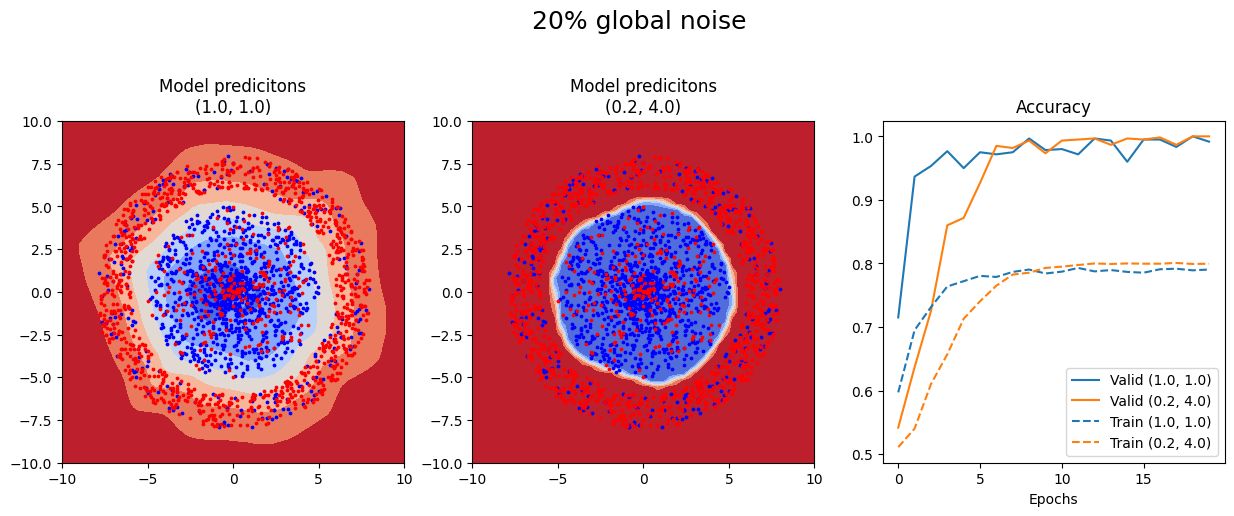

In [12]:
plot_synthetic_results(*datasets['noise free'], results['noise free'], 'Noise free dataset')
plot_synthetic_results(*datasets['margin'], results['margin'], '20% margin noise')
plot_synthetic_results(*datasets['global'], results['global'], '20% global noise')

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


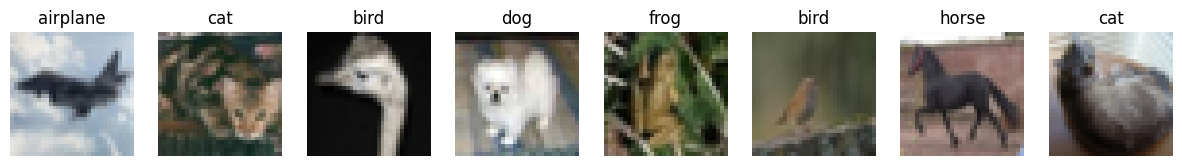

In [14]:
plot_cifar(X_train, y_train)

In [15]:
y_train_small_noise, small_noise_idx = mix_cifar(y_train, 0.1)
y_train_large_noise, large_noise_idx = mix_cifar(y_train, 0.2)

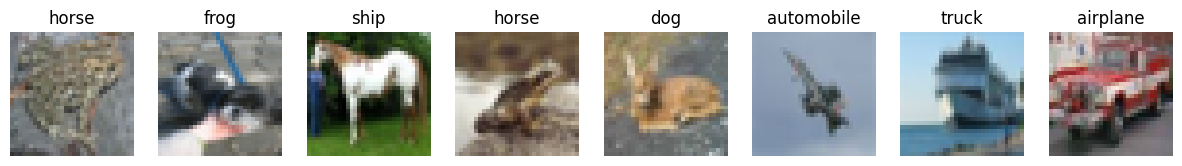

In [16]:
plot_cifar(X_train[small_noise_idx], y_train_small_noise[small_noise_idx])

In [17]:
X_train = resnet50.preprocess_input(X_train)
X_valid = resnet50.preprocess_input(X_valid)

y_train = to_categorical(y_train)
y_train_small_noise = to_categorical(y_train_small_noise)
y_train_large_noise = to_categorical(y_train_large_noise)
y_valid = to_categorical(y_valid)

In [18]:
def cifar_model():
    return Sequential([
        UpSampling2D((7, 7), input_shape=(32, 32, 3)),
        ResNet50(
            include_top=False,
            weights="imagenet",
            classes=10,
            pooling='avg'
        ),
        Flatten(),
        Dense(1024),
        Dense(512),
        Dense(10)
    ])

In [19]:
model = cifar_model()
model.save_weights('model.h5')

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
datasets = {'noise free': (X_train, y_train),
            'small': (X_train, y_train_small_noise),
            'large': (X_train, y_train_large_noise)}
temp_vals = [(1.0, 1.0), (0.8, 1.2), (0.5, 2.0), (0.2, 4.0)]

In [ ]:
best_lr = {}
finders = {}
for temps in temp_vals:
    model.load_weights('model.h5')
    model.compile(loss=BiTemperedWrapper(*temps), optimizer=SGD(momentum=0.8), metrics=['accuracy'])

    lr_finder = LRFinder(model)
    lr_finder.find(X_train, y_train, start_lr=1e-10, end_lr=100, batch_size=64)
    lr, loss = get_best_lr(lr_finder)
    best_lr[temps] = lr
    finders[temps] = lr_finde

 12/782 [..............................] - ETA: 10:44:57 - loss: 3.1291 - accuracy: 0.0924

In [ ]:
plot_lr_finding_results(finders, get_best_lr)

In [ ]:
results = {}
for dataset_name, (X_data, y_data) in datasets.items():
    results[dataset_name] = {}
    for temps in temp_vals:
        model.load_weights('model.h5')
        results[dataset_name][temps] = {}
        model.compile(loss=BiTemperedWrapper(*temps), optimizer=SGD(learning_rate=best_lr[temps], momentum=0.8), metrics=['accuracy'])
        history = model.fit(X_data, y_data, validation_data=(X_valid, y_valid), batch_size=64, epochs=40, steps_per_epoch=100)

        results[dataset_name][temps]['history'] = history.history
        np.save(f'{dataset_name}_{temps}', history.history)
        model.save_weights(f'{dataset_name}_{temps}.h5')

In [ ]:
plot_cifar_results(results['noise free'], 'Noise free dataset', max_annotations=[[0.88,0.9],[0.6,0.9],[0.75,0.75],[0.75,0.5]])
plot_cifar_results(results['small'], '10% noise', max_annotations=[[0.52,0.9],[0.1,0.9]])
plot_cifar_results(results['large'], '20% noise', max_annotations=[[0.57,0.9],[0.12,0.9]])